# Low-level interface to the CHONK model

This notebooks describes how to use the model with the low-level interface, _i.e_ intereacting with the pybinded c++ code

In [1]:
import CHONK_cpp as ch
import time
import numpy as np
import fastscapelib_fortran as fs
import lsdtopytools as lsd
from scipy.ndimage import gaussian_filter
import numba as nb
from matplotlib import pyplot as plt
import lsdnumbatools as lsdnb
%matplotlib inline
from IPython.display import clear_output, display
nrows = 100
ncols = 100
xres = 50
yres = 50

xmin = 0
xmax = ncols*yres
ymin = 0
ymax = nrows*xres
# Z = np.load("stack_breaker.npy")
Z = np.random.rand(nrows,ncols)
# Z = np.load("SS_100_100_MFA.npy")
lsd.raster_loader.save_raster(Z.reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","v3_current_Z.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster(np.arange(nrows*ncols).reshape(nrows,ncols).astype(np.int32),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","v3_current_ID.tif", fmt = 'GTIFF')

model = ch.ModelRunner( 1, ["drainage_area","move","CHARLIE_I"], "MF_fastscapelib_threshold_SF") #"MF_fastscapelib_threshold_SF") # "MF_fastscapelib" #"SPIL_Howard_Kerby_1984"
model.set_lake_switch(True)
model.update_array_double_param("surface_elevation", Z.ravel())
model.update_double_param("x_min", xmin)
model.update_double_param("y_min", ymin)
model.update_double_param("x_max", xmax)
model.update_double_param("y_max", ymax)
model.update_double_param("dx", xres)
model.update_double_param("dy", yres)
model.update_double_param("no_data", -9999)
model.update_int_param("n_rows", nrows)
model.update_int_param("n_cols", ncols)
model.update_int_param("n_elements", nrows*ncols)
model.update_array_double_param("surface_elevation_tp1", np.copy(Z.ravel()))
model.update_array_double_param("sed_height", np.zeros_like(Z.ravel()))
model.update_array_double_param("sed_height_tp1", np.zeros_like(Z.ravel()))
model.update_array_double_param("lake_depth", np.zeros_like(Z.ravel()))
model.update_double_param("depths_res_sed_proportions", 1.)
model.update_double_param("threshold_single_flow", 1e6)

active = np.zeros((nrows,ncols), dtype = np.int)
# active[1:-1,1:-1:] = 1
active[1:-1,:] = 1

model.update_array_int_param("active_nodes", active.ravel())

# Labelisation for CHARLIE_I
label_list = []
label_list.append(ch.label(0))
label_list[0].set_double_attribute("SPIL_m", 0.45);
label_list[0].set_double_attribute("SPIL_n", 1);
label_list[0].set_double_attribute("SPIL_K", 1e-5);
label_list[0].set_double_attribute("CHARLIE_I_Kr", 1e-5);
label_list[0].set_double_attribute("CHARLIE_I_Ks", 2e-5);
label_list[0].set_double_attribute("CHARLIE_I_V", 1);
label_list[0].set_double_attribute("CHARLIE_I_dimless_roughness", 1);
label_list[0].set_double_attribute("CHARLIE_I_dstar", 1);
label_list[0].set_double_attribute("CHARLIE_I_threshold_incision", 0);
label_list[0].set_double_attribute("CHARLIE_I_threshold_entrainment", 0);
label_list.append(ch.label(1))
label_list[1].set_double_attribute("SPIL_m", 0.45);
label_list[1].set_double_attribute("SPIL_n", 1);
label_list[1].set_double_attribute("SPIL_K", 1e-5);
label_list[1].set_double_attribute("CHARLIE_I_Kr", 1e-5);
label_list[1].set_double_attribute("CHARLIE_I_Ks", 2e-5);
label_list[1].set_double_attribute("CHARLIE_I_V", 1);
label_list[1].set_double_attribute("CHARLIE_I_dimless_roughness", 1);
label_list[1].set_double_attribute("CHARLIE_I_dstar", 1);
label_list[1].set_double_attribute("CHARLIE_I_threshold_incision", 0);
label_list[1].set_double_attribute("CHARLIE_I_threshold_entrainment", 0);

label_array = np.ones_like(Z,dtype = np.int);
# label_array[round(nrows/4):3*round(nrows/4), :] = 0;
label_array = label_array.ravel()

model.initialise_label_list(label_list)
model.update_label_array(label_array.ravel())


ch.set_DEBUG_switch_nodegraph(["SAFE_STACK_STOPPER", "EXTENSIVE_STACK_INFO"], [True,True]) 
print("Ready!")

Ready!


In [ ]:
uplift = np.zeros((nrows,ncols))
# uplift[1:-1,1:-1:] = 0.001
uplift[1:-1,:] = 0.001
# uplift[20:40,:] = 0.0005
# uplift[10:20,:] = 0.001
# uplift[25:60,:] +=  0.003
# uplift[60:85:,:] +=  0.002      
uplift = uplift.ravel() 
dt = 500
model.update_timestep(dt)
model.update_array_double_param("erodibility_K", np.zeros_like(Z.ravel())+1e-5)
model.set_lake_switch(False)
save_question_mark = False
save_mod = 20

timers = {}
timers["preproc"] = []
timers["init_node_graph"] = []
timers["run"] = []
# timers["preproc"] = []

checkMBlist = []

# for i in range(1):
for i in range(100):
    this_timer = time.time()
    new_elev = model.get_array_double_param("surface_elevation_tp1") + (uplift * dt)
    new_elev += np.random.rand(new_elev.shape[0]) * 1e-6
    
    

    model.update_array_double_param("surface_elevation", new_elev)
    model.update_array_double_param("surface_elevation_tp1", new_elev)
    model.update_array_double_param("sed_height", np.copy(model.get_array_double_param("sed_height_tp1")))
    timers["preproc"].append(time.time() - this_timer)
    this_timer = time.time()
    
    model.initiate_nodegraph()
    timers["init_node_graph"].append(time.time() - this_timer)
    this_timer = time.time()
    model.run()
    timers["run"].append(time.time() - this_timer)
    
    dtprint = 1
    clear_output() if (i%dtprint == 0) else 0
    display(str(i+1)) if (i%dtprint == 0) else 0
    
#     checkMBlist.append( np.nansum(model.get_water_flux().reshape(nrows,ncols)[0,:]) + np.nansum(model.get_water_flux().reshape(nrows,ncols)[-1,:]) + np.nansum(model.get_array_double_param("lake_depth"))* xres *yres / dt)

    
    if(save_question_mark):
        if(i%save_mod == 0):
            name = str(i)
            while(len(name)<4):
                name = "0" + name
            Zp1 = model.get_array_double_param("surface_elevation_tp1")
            fig,ax = plt.subplots(figsize = (10,10))
            cb = ax.imshow(Zp1.reshape(nrows,ncols), vmin = 0, cmap = "gist_earth", extent = [xmin,xmax,ymin,ymax])
            plt.colorbar(cb)
            HS = np.zeros_like(Zp1).reshape(nrows,ncols)
            tester = np.copy(Zp1).reshape(nrows,ncols)

#             tester = gaussian_filter(tester, sigma=1)
#             tester = tester - tester.min()
#             tester = tester/np.median(tester) * 1000
            lsdnb.lsdnb.hillshading(tester.reshape(nrows,ncols),xres,yres,ncols,nrows,HS,np.deg2rad(60),np.deg2rad(125),1)
#             HS = HS - np.nanmin(HS)
#             HS = HS/np.median(HS)
#             HS = HS/np.nanmax(HS)
            ax.imshow(HS.reshape(nrows,ncols),vmin = 0, vmax = 255,  cmap = "gray", extent = [xmin,xmax,ymin,ymax], alpha = 0.35)
            
            lake = model.get_array_double_param("lake_depth").reshape(nrows,ncols)
            lake = np.abs(lake)
            lake[lake<=0] = np.nan
            ax.imshow(lake,vmin =-5, vmax = -4, cmap = "Blues", extent = [xmin,xmax,ymin,ymax])
            ax.set_xlabel("X (m)")
            ax.set_ylabel("Y (m)")
            plt.savefig("demo_lake_tecto/anim%s.jpg"%(name), dpi = 300)
            plt.close(fig)




for key,val in timers.items():
    print(key, "took", np.median(np.array(val)) )
    

'45'

0.4178346160165127


Text(0, 0.5, 'Y (m)')

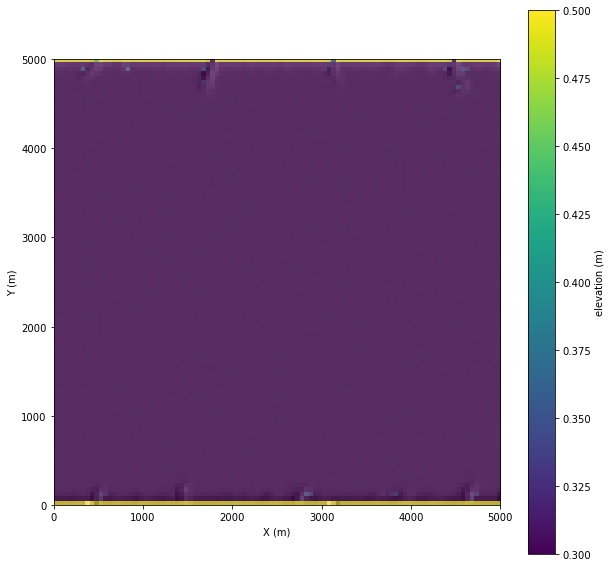

In [3]:
Zp1 = model.get_array_double_param("surface_elevation_tp1")
print(np.min(Zp1))

fig,ax = plt.subplots(figsize = (10,10))

# cb = ax.imshow(Z.reshape(raster["nrows"],raster["ncols"])- Zp1.reshape(raster["nrows"],raster["ncols"]), 
#      cmap = "viridis")
# model.get_water_flux()

noerr = np.copy(Zp1.reshape(nrows,ncols))
noerr[noerr>0] = np.nan
 
cb = ax.imshow(Zp1.reshape(nrows,ncols), vmin = 0, cmap = "gist_earth", extent = [xmin,xmax,ymin,ymax])

lake = model.get_array_double_param("lake_depth").reshape(nrows,ncols)
lake = np.abs(lake)
lake[lake<=0] = np.nan
ax.imshow(lake,vmin = -5, vmax = -4, cmap = "Blues", extent = [xmin,xmax,ymin,ymax])

# logwat = np.log10(model.get_water_flux().reshape(nrows,ncols))
# cb = ax.imshow(logwat, vmin = 3, cmap = "Blues")
# cb = ax.imshow(np.log10(model.get_water_flux().reshape(nrows,ncols)), vmin = 3, cmap = "Blues", extent = [xmin,xmax,ymin,ymax])
# logwat[logwat<6] = np.nan
# cb = ax.imshow(logwat, vmin = 3, cmap = "Blues")



# cb = ax.imshow((Zp1 - tempsave).reshape(nrows,ncols), vmin = 0, cmap = "gist_earth", extent = [xmin,xmax,ymin,ymax])
# cb = ax.imshow(model.get_other_attribute("lake_depth").reshape(nrows,ncols), vmin = 0,     cmap = "viridis")
# cb = ax.imshow(model.get_erosion_flux().reshape(nrows,ncols), cmap = "viridis", extent = [xmin,xmax,ymin,ymax])
# cb = ax.imshow(model.get_deposition_flux().reshape(nrows,ncols), cmap = "viridis", extent = [xmin,xmax,ymin,ymax])

# Sediment stuff plotting

list_of_proportions = model.get_label_tracking_results()

# cb = ax.imshow(np.log10(model.get_sediment_flux()).reshape(nrows,ncols), cmap = "viridis", extent = [xmin,xmax,ymin,ymax])
# cb = ax.imshow((model.get_sediment_flux() / model.get_water_flux()).reshape(nrows,ncols), cmap = "viridis", extent = [xmin,xmax,ymin,ymax])
# cb = ax.imshow(list_of_proportions[1].reshape(nrows,ncols), cmap = "viridis" ) #, vmin =0, vmax = 1)

# # # cb = ax.imshow(model.get_all_nodes_in_depression().reshape(nrows,ncols), cmap = "viridis")
# cb = ax.imshow(model.DEBUG_get_preacc().reshape(nrows,ncols), cmap = "viridis")

cb = ax.imshow(model.get_array_double_param("sed_height_tp1").reshape(nrows,ncols), cmap = "viridis", extent = [xmin,xmax,ymin,ymax], vmin = 0.3, vmax =0.5)
# cb = ax.imshow(model.get_array_double_param("sed_height_tp1").reshape(nrows,ncols), cmap = "viridis", vmax =0.0001, extent = [xmin,xmax,ymin,ymax])

HS = np.zeros_like(Zp1).reshape(nrows,ncols)
tester = np.copy(Zp1).reshape(nrows,ncols)

lsdnb.lsdnb.hillshading(tester.reshape(nrows,ncols),xres,yres,ncols,nrows,HS,np.deg2rad(60),np.deg2rad(125),1)

ax.imshow((HS.reshape(nrows,ncols)),vmin = 0, vmax = 255,  cmap = "gray", extent = [xmin,xmax,ymin,ymax], alpha = 0.35)


# cb = ax.imshow(Z.reshape(raster["nrows"],raster["ncols"])[600:700,400:500] - Zp1.reshape(raster["nrows"],raster["ncols"])[600:700,400:500], 
#     vmin = -0.1,vmax = 0.5, cmap = "viridis")
# cb = ax.imshow(Z.reshape(raster["nrows"],raster["ncols"])[550:650,400:500], cmap = "viridis",vmin = 500, vmax = 800 )
# plt.colorbar(cb, label = r"Erosion rates $(mm.yrs^{-1})$")
plt.colorbar(cb, label = r"elevation (m)")
ax.set_xlabel("X (m)")
ax.set_ylabel("Y (m)")


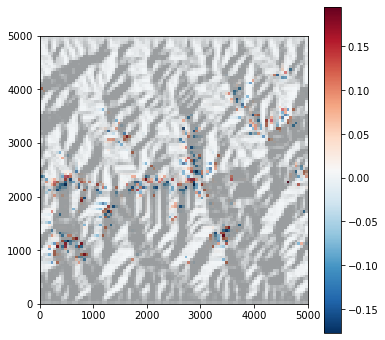

In [4]:
# Checking mass balance

total_accumulable = nrows*ncols*xres*yres
total_accumulated = np.nansum(model.get_water_flux().reshape(nrows,ncols)[0,:]) + np.nansum(model.get_water_flux().reshape(nrows,ncols)[-1,:]) + np.nansum(model.get_array_double_param("lake_depth"))* xres *yres / dt
print(total_accumulable)
print(total_accumulated)
print("Lake depth sum", np.nansum(model.get_array_double_param("lake_depth")) * xres * yres/dt)
print(np.nansum(model.get_array_double_param("lake_depth")), xres*yres )

25000000
25000000.0
Lake depth sum 0.0
0.0 2500


In [ ]:
fig, ax = plt.subplots(figsize = (9,6))
ax.set_facecolor("k")
ax.plot(checkMBlist, lw = 3, color = "w")
ax.grid(color = "gray")
ax.axhline(nrows*ncols*xres*yres, color = "pink")

# Fantastic inputs and where to find them

The model can take a lot of parameters, which looks scary, but actually this is just to induce flexibility and most of them will be used by defaults in higher interface.

## Essential

These inputs are **essential**, i.e. the model won't simply run without it.

|Parameter string|c++ object|value type|description
|---|---|---|---|
|   |   |   |   |
|   |   |   |   |
|   |   |   |   |

In [ ]:
# Labelisation for SPL
label_list = []
label_list.append(ch.label(0))
label_list[0].set_double_attribute("SPIL_m", 0.45);
label_list[0].set_double_attribute("SPIL_n", 1.11);
label_list[0].set_double_attribute("SPIL_K", 1e-5);
label_list.append(ch.label(1))
label_list[1].set_double_attribute("SPIL_m", 0.45);
label_list[1].set_double_attribute("SPIL_n", 1.11);
label_list[1].set_double_attribute("SPIL_K", 3e-5);

In [ ]:
# Labelisation for CHARLIE_I
label_list = []
label_list.append(ch.label(0))
label_list[0].set_double_attribute("SPIL_m", 0.45);
label_list[0].set_double_attribute("SPIL_n", 1.11);
label_list[0].set_double_attribute("CHARLIE_I_Kr", 1e-5);
label_list[0].set_double_attribute("CHARLIE_I_Ks", 5e-5);
label_list[0].set_double_attribute("CHARLIE_I_V", 1e-2);
label_list[0].set_double_attribute("CHARLIE_I_dimless_roughness", 0.01);
label_list[0].set_double_attribute("CHARLIE_I_dstar", 1);
label_list[0].set_double_attribute("CHARLIE_I_threshold_incision", 0);
label_list[0].set_double_attribute("CHARLIE_I_threshold_entrainment", 0);
label_list.append(ch.label(1))
label_list[1].set_double_attribute("SPIL_m", 0.45);
label_list[1].set_double_attribute("SPIL_n", 1.11);
label_list[1].set_double_attribute("CHARLIE_I_Kr", 2e-5);
label_list[1].set_double_attribute("CHARLIE_I_Ks", 5e-5);
label_list[1].set_double_attribute("CHARLIE_I_V", 2e-2);
label_list[1].set_double_attribute("CHARLIE_I_dimless_roughness", 0.05);
label_list[1].set_double_attribute("CHARLIE_I_dstar", 1);
label_list[1].set_double_attribute("CHARLIE_I_threshold_incision", 0);
label_list[1].set_double_attribute("CHARLIE_I_threshold_entrainment", 0);

In [8]:
model.get_water_flux()

array([0., 0., 0., ..., 0., 0., 0.])

In [43]:
np.save("200_300_demo_dem.npy", model.get_array_double_param("surface_elevation"))

In [5]:
idx = []
tid = -1
all_bas = []
for A in model.get_DEBUG_connbas():
    tid+=1
    if(A[0] == 129 or A[1] == 129):
        print(A)
        idx.append(tid)
print("-------------")
connodes =  model.get_DEBUG_connode()
for i in idx:
    print(connodes[i])

-------------


In [7]:
tree = model.get_mstree_translated()
for furb in tree:
    if(furb[0] == 235 or furb[1] == 235):
        print("bite")


bite
bite


In [3]:
new_elev = new_elev.reshape(nrows,ncols)
# new_elev[20:20,15:15] = new_elev[20:20,15:15] -  20
new_elev[0:2,:] = 0
new_elev[-2:,:] = 0
new_elev = new_elev.ravel()
model.update_array_double_param("surface_elevation_tp1", new_elev)
model.update_array_double_param("surface_elevation", new_elev)


NameError: name 'new_elev' is not defined

In [ ]:
this_K = np.zeros_like(Z.ravel())+1e-4

popup_elev = ch.pop_elevation_to_SS_SF_SPIL(fstctx.stack -1, fstctx.rec -1,fstctx.length , uplift, this_K, 0.9, 0.45, xres*yres)
pZ = np.copy(popup_elev)

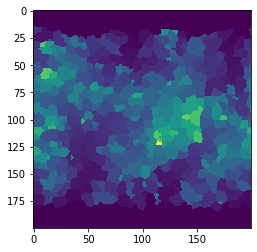

In [6]:
plt.imshow(pZ.reshape(nrows, ncols))
model.update_array_double_param("surface_elevation_tp1", pZ)

model.update_array_double_param("surface_elevation", pZ)


In [13]:
mfst = np.copy(fstctx.mstack.astype('int') - 1)
print(model.get_array_int_param("MF_stack") - mfst)
print(np.unique(model.get_array_int_param("MF_stack") - mfst))

[0 0 0 ... 0 0 0]
[0]


In [5]:
# Prec = fstctx.rec - 1
# don = fstctx.don.transpose() - 1
# ndon = fstctx.ndon
# rec = fstctx.mrec.transpose() - 1
# # print(model.get_array_int_param("MF_rec")[792])
# # print(model.get_array_int_param("MF_stack")[2080])
# # print(Prec[2080])
# # print(model.DEBUG_get_receivers_at_node(2390))
# # print(model.DEBUG_get_donors_at_node(2390))
# rec[300]
# ndon[300]
# for i in range(100):
#     print(model.DEBUG_get_receivers_at_node(i), end = "||")

print(model.DEBUG_get_receivers_at_node(323), end = "||")
print(model.DEBUG_get_Sreceivers_at_node(323), end = "||")
for i in range(nrows,nrows*ncols - nrows):
    if(len(model.DEBUG_get_receivers_at_node(i)) == 0):
        print(i)

[323]||323||

In [5]:
lsd.raster_loader.save_raster(model.get_array_double_param("surface_elevation").reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","nodegraphv2_topo.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster((model.get_array_double_param("surface_elevation") + model.get_array_double_param("lake_depth")).reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","nodegraphv2_topolake.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster(np.arange(nrows*ncols).astype(np.int32).reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","nodegraphv2_ID.tif", fmt = 'GTIFF')
lsd.raster_loader.save_raster(np.log10(model.get_water_flux().reshape(nrows,ncols)).reshape(nrows,ncols),
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","nodegraphv2_logDA.tif", fmt = 'GTIFF')
arr = model.get_array_double_param("lake_depth").reshape(nrows,ncols)
arr[arr<=0] = -9999
lsd.raster_loader.save_raster(arr,
   0,xres*ncols,yres*nrows,0,xres,"epsg:32635","nodegraphv2_lake_depth.tif", fmt = 'GTIFF')
caspers = model.get_broken_nodes()
ARR = np.zeros_like(Z.ravel())
ARR[caspers]=1
lsd.raster_loader.save_raster(ARR.reshape(nrows,ncols),0,xres*ncols,yres*nrows,0,xres,"epsg:32635","nodegraphv2_broken_nodes.tif", fmt = 'GTIFF')

In [16]:
model.update_double_param("threshold_single_flow", 1e5)


In [8]:
np.save("SS_100_100_MFA.npy",model.get_array_double_param("surface_elevation"))

In [10]:
caspers = model.get_broken_nodes()
print(caspers)

[]


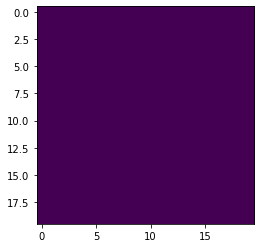

In [11]:
ARR = np.zeros_like(Z.ravel())
ARR[caspers]=1
plt.imshow(ARR.reshape(nrows,ncols))

In [16]:
from io import StringIO
import pandas as pd
res = """ID|donor|score
79|178|1638
80|181|537
81|182|536
180|281|534
877|978|507
976|1077|470
1175|1176|460
1274|1273|1593
1275|1176|460
1374|1273|1593
1375|1276|461
1376|1477|435
1474|1373|1594
1475|1576|433
1476|1577|431
1573|1672|1576
1574|1673|1577
1575|1676|432
1674|1774|1537
1675|1776|415
1775|1776|415
2000|1999|705
2001|1900|715
2002|1901|717
2003|1902|722
2004|1905|848
2005|1906|847
2073|1974|1535
2079|1980|413
2080|1981|412
2085|1986|388
2097|1998|707
2098|1999|705
2099|1999|705
2105|2006|2468
2106|2207|2102
2172|2071|1546
2174|2075|1536
2175|2076|426
2177|2076|426
2182|2282|2616
2183|2282|2616
2196|2095|709
2198|2197|2097
2200|2399|2160
2204|2305|2483
2205|2305|2483
2206|2207|2102
2271|2171|2135
2275|2176|427
2276|2176|427
2287|2386|3221
2294|2395|3340
2295|2396|3337
2297|2197|2097
2298|2197|2097
2299|2398|2159
2300|2399|2160
2304|2405|2482
2371|2272|2136
2390|2289|367
2392|2491|3319
2393|2492|3320
2394|2495|3305
2400|2399|2160
2401|2500|3285
2404|2405|2482
2467|2368|1532
2469|2368|1532
2470|2471|2993
2489|2588|3216
2501|2600|3283
2502|2603|2162
2503|2603|2162
2504|2603|2162
2568|2669|3066
2602|2702|2161
2604|2603|2162
2703|2702|2161"""
df = pd.read_csv(StringIO(res.replace("|",",")))

In [17]:
df[df['score'] == df['score'].min()]

,ID,donor,score
60,2390,2289,367


In [3]:
["bite"] +[2]

['bite', 2]

In [3]:
fs.fastscape_init()
fs.fastscape_set_nx_ny(ncols,nrows)
fs.fastscape_setup()
fs.fastscape_set_xl_yl(xmax - xmin, ymax - ymin)
fs.fastscape_set_bc(1010)
fstctx = fs.fastscapecontext
fstctx.p = 3
fstctx.h = new_elev
fs.flowrouting()

In [9]:
Prec = fstctx.rec - 1
print(Prec[152])

53


In [13]:
model.update_double_param("threshold_single_flow", 1e5)


In [8]:
lab0 = ch.label(0)
lab0.set_int_attribute("n_SPL",3)
lab0.set_double_attribute("m_SPL",3.11)
lab0.set_double_array_attribute("proportion_stuff",np.array([2,3.5,45.7]))

In [11]:
lablist = [lab0]
model.reinitialise_label_list()
model.initialise_label_list(lablist)

In [10]:
H_star = 1
V = 1
Ks = 2e-5
Kr = 1e-5
r = 1



aimed_H = - H_star * np.log(1 - (V/((Ks*r)/Kr + V)))
print(aimed_H)

0.4054651081081643
